# Notebook: NLP & LSTM pour prédiction du type de sujet conernant les réclamations et pleintes à l'encontre de services financiers


# Vue d'ensemble du pipeline

1. **Analyse des données**

    - **Analyse des valeurs manquantes**
    - **Analyse de la disponibilités et distribution des données**
    - **Sélection des données et variables pertinentes**


2. **Traintement de données**
    - **Imports** : Chargement des bibliothèques.
    - **Lecture et exploration** : Chargement du dataset, visualisation et gestion des valeurs manquantes.
    - **Prétraitement textuel** : Nettoyage multi-étapes pour réduire le bruit.
    - **Tokenisation** : Passage du texte brut aux tokens.
    - **Filtrage des tokens** : Stopwords et longueur minimale.
    - **Réalignement du format** : Reconstruction en chaîne pour la vectorisation.
    - **Construction du vocabulaire (Tokenizer Keras)** : Explication du mapping mots→indices, .
    - **Padding** : Uniformisation de la longueur des séquences.

2. **LSTM Model**
    - **Architecture du modèle** : Embedding, LSTM bidirectionnel, couches denses.
    - **Compilation et build** : Choix de la perte, optimiseur, build explicite pour révéler les paramètres.
    - **Entraînement** : Early stopping, batch size, epochs.
    - **Evaluation des performances sur les données de test**

3. **Gestion des class inbalance** 
    - **Utilisation de sur échantillonnage**
    - **Pondération des classes durant l'entrainement**

4. **Validation croisées des paramètres de l'architecture du model pour améliorations des performances** 
    - **Recherche des paramètres optimaux**
    - **Respécification du modèle**
    - **Comparaison des performances**




In [304]:
import plotly.express as px
import polars as pl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import re
import string
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Bidirectional, LSTM, Dropout, BatchNormalization, SpatialDropout1D
from tensorflow.keras.layers import Embedding
from keras.initializers import Constant
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import optimizers, layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout, Embedding
import tensorflow as tf




# 1. Analyse et Traitement de données

## A) Exploration & Statistiques

 **Sélection des deux variables d’intérêt**

In [305]:
file = 'consumer_complaints.csv'

#on traite le code postal comme texte
schema_fix = {"zipcode": pl.Utf8}

df = pl.read_csv(
    file,
    schema_overrides=schema_fix,
)

print(df.shape)
display(df.head())

(555957, 18)


date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,complaint_id
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,i64
"""08/30/2013""","""Mortgage""","""Other mortgage""","""Loan modification,collection,f…",null,null,null,"""U.S. Bancorp""","""CA""","""95993""",null,null,"""Referral""","""09/03/2013""","""Closed with explanation""","""Yes""","""Yes""",511074
"""08/30/2013""","""Mortgage""","""Other mortgage""","""Loan servicing, payments, escr…",null,null,null,"""Wells Fargo & Company""","""CA""","""91104""",null,null,"""Referral""","""09/03/2013""","""Closed with explanation""","""Yes""","""Yes""",511080
"""08/30/2013""","""Credit reporting""",null,"""Incorrect information on credi…","""Account status""",null,null,"""Wells Fargo & Company""","""NY""","""11764""",null,null,"""Postal mail""","""09/18/2013""","""Closed with explanation""","""Yes""","""No""",510473
"""08/30/2013""","""Student loan""","""Non-federal student loan""","""Repaying your loan""","""Repaying your loan""",null,null,"""Navient Solutions, Inc.""","""MD""","""21402""",null,null,"""Email""","""08/30/2013""","""Closed with explanation""","""Yes""","""Yes""",510326
"""08/30/2013""","""Debt collection""","""Credit card""","""False statements or representa…","""Attempted to collect wrong amo…",null,null,"""Resurgent Capital Services L.P…","""GA""","""30106""",null,null,"""Web""","""08/30/2013""","""Closed with explanation""","""Yes""","""Yes""",511067


**Analyse et suppression des doublons**

In [306]:
# 1. Nombre total de lignes
total = df.height

# 2. Nombre de lignes uniques (sur TOUTES les colonnes)
n_unique = df.unique().height

# 3. Calcul des doublons exacts
n_dups_exact = total - n_unique
print(f"Doublons exacts (toutes colonnes confondues) : {n_dups_exact}")

# 4. Doublons sur complaint_id seulement
n_dups_id = df.filter(pl.col("complaint_id").is_duplicated()).height
print(f"Doublons sur complaint_id : {n_dups_id}")

Doublons exacts (toutes colonnes confondues) : 0
Doublons sur complaint_id : 0


 **Sélection des deux variables d’intérêt**

In [307]:
# Fonction de sélection & synthèse des valeurs manquantes

def select_with_missing(df: pl.DataFrame, columns: list[str]) -> tuple[pl.DataFrame, pl.DataFrame]:
    """
    Sélectionne les colonnes demandées et renvoie :
      - df_small : DataFrame réduit aux colonnes choisies
      - na_summary : DataFrame (column, missing, percent) décrivant
                     les NA de ces colonnes
    """
    # 1) sélection des colonnes
    df_small = df.select(columns)

    # 2) calcul du total de lignes
    total = df_small.height

    # 3) résumé des NA
    na_summary = (
        df_small
        .null_count()                       # 1×n colonnes avec counts
        .melt()                             # déplie colonnes en lignes (variable,value)
        .rename({                           # renommage pour clarté
            "variable": "column",
            "value":    "missing"
        })
        .with_columns([                     # ajout du pourcentage
            (pl.col("missing") / total * 100)
            .round(2)
            .alias("percent")
        ])
        .sort("percent", descending=True) # tri par % décroissant
    )            # tri par % décroissant


    return df_small, na_summary

# ─────────────────────────────────────────────────────────────────────────
# Exécution sur vos deux variables d’intérêt
cols = ["product", "consumer_complaint_narrative"]
df_small, na_df = select_with_missing(df, cols)

# Affichage des résultats
print("=== Sous-DataFrame réduit ===")
display(df_small.head())
print(df_small.shape)

print("\n=== Synthèse des valeurs manquantes ===")
display(na_df)

=== Sous-DataFrame réduit ===


/var/folders/hh/87rk0r4519j1t1s8k96y4l_r0000gn/T/ipykernel_3885/101606361.py:20: DeprecationWarning:

`DataFrame.melt` is deprecated. Use `unpivot` instead, with `index` instead of `id_vars` and `on` instead of `value_vars`



product,consumer_complaint_narrative
str,str
"""Mortgage""",null
"""Mortgage""",null
"""Credit reporting""",null
"""Student loan""",null
"""Debt collection""",null


(555957, 2)

=== Synthèse des valeurs manquantes ===


column,missing,percent
str,u32,f64
"""consumer_complaint_narrative""",489151,87.98
"""product""",0,0.0


**Répartition des produits dans le jeu de données**

In [308]:
# --- 1) Sous-DataFrame réduit ---
df_small = df.select([
    pl.col("product"),
    pl.col("consumer_complaint_narrative")
])

# --- 2) Répartition de "product" ---
prod_counts = (
    df_small
      .group_by("product")                                 # Polars eager utilise group_by :contentReference[oaicite:0]{index=0}
      .agg(pl.count().alias("freq"))                       # compte les lignes par produit
      .sort("freq", descending=True)                       # tri décroissant
      .to_pandas()                                         # conversion pour Plotly
)
# Calcul du pourcentage avec round() Python
prod_counts["percent"] = (
    prod_counts["freq"] / prod_counts["freq"].sum() * 100
).round(2)

fig = px.bar(
    prod_counts,
    x="product", y="percent",
    title="Répartition des produits dans le jeu de données",
    labels={"percent":"% des plaintes", "product":"Produit"},
    text="percent"               # on affiche la valeur de la colonne percent
)

fig.update_traces(
    texttemplate="%{text:.2f} %",  # format avec deux décimales + symbole %
    textposition="outside"         # place le texte au-dessus de chaque barre
)

fig.update_layout(
    uniformtext_minsize=8,         # taille mini du texte
    uniformtext_mode='hide'        # cache les textes trop grands
)

fig.show()

/var/folders/hh/87rk0r4519j1t1s8k96y4l_r0000gn/T/ipykernel_3885/3032611547.py:11: DeprecationWarning:

`pl.count()` is deprecated. Please use `pl.len()` instead.



**Taux de narratif manquant par produit**

In [309]:
miss_by_prod = (
    df_small
    .with_columns([
        (pl.col("consumer_complaint_narrative").is_null()
           .cast(pl.UInt8))  # directement 0/1
        .alias("is_missing")
    ])
    .group_by("product")
    .agg([
        pl.sum("is_missing").alias("nb_missing"),
        (
            pl.sum("is_missing")
            / pl.count("is_missing")  # nombre de lignes par groupe
            * 100
        )
        .round(2)
        .alias("pct_missing")
    ])
    .sort("pct_missing", descending=True)
    .to_pandas()
)

import plotly.express as px
fig = px.bar(
    miss_by_prod,
    x="product", y="pct_missing", text="pct_missing",
    title="Taux de narratif manquant par produit",
    labels={"pct_missing":"% sans texte", "product":"Produit"}
)
fig.update_traces(texttemplate="%{text:.2f} %", textposition="outside")
fig.update_layout(xaxis_tickangle=45)
fig.show()


**Répartition des produits (plaintes AVEC texte)**

In [310]:
# 1) Filtrer les lignes AVEC un texte de plainte
with_text = df_small.filter(
    pl.col("consumer_complaint_narrative").is_not_null()
)

# 2) Nombre total et aperçu
n_with = with_text.height
pct_with = round(n_with / df_small.height * 100, 2)
print(f"Nombre de plaintes AVEC texte : {n_with} ({pct_with} %)")
display(with_text.head(10))

# 3) Calcul de la répartition par produit (freq + percent)
counts_with = (
    with_text
    .group_by("product")
    .agg(pl.count().alias("freq"))
    .sort("freq", descending=True)
    .to_pandas()
)
counts_with["percent"] = (
    counts_with["freq"] / counts_with["freq"].sum() * 100
).round(2)

# 4) Bar chart avec pourcentages sur chaque barre
fig = px.bar(
    counts_with,
    x="product",
    y="percent",
    text="percent",
    title="Répartition des produits (plaintes AVEC texte)",
    labels={"percent":"% des plaintes avec texte", "product":"Produit"},
)

fig.update_traces(
    texttemplate="%{text:.2f} %",  # deux décimales + symbole %
    textposition="outside"
)
fig.update_layout(
    xaxis_tickangle=45,
    uniformtext_minsize=8,
    uniformtext_mode='hide',
    yaxis=dict(range=[0, counts_with["percent"].max() * 1.1])  # un peu d’espace en haut
)
fig.show()

Nombre de plaintes AVEC texte : 66806 (12.02 %)


product,consumer_complaint_narrative
str,str
"""Debt collection""","""XXXX has claimed I owe them {$…"
"""Consumer Loan""","""Due to inconsistencies in the …"
"""Mortgage""","""In XX/XX/XXXX my wages that I …"
"""Mortgage""","""I have an open and current mor…"
"""Mortgage""","""XXXX was submitted XX/XX/XXXX.…"
"""Mortgage""","""Experian is reporting my OPEN …"
"""Mortgage""","""This complaint is against Well…"
"""Mortgage""","""I spoke to XXXX of green tree …"
"""Credit card""","""i opened XXXX Bank of America …"


/var/folders/hh/87rk0r4519j1t1s8k96y4l_r0000gn/T/ipykernel_3885/2469596007.py:16: DeprecationWarning:

`pl.count()` is deprecated. Please use `pl.len()` instead.



**Pourcentage de textes manquants par mois/années**

In [311]:
# Extrait le mois/année de date_received
df_time = (
  df
  .with_columns([
    pl.col("date_received")
      .str.strptime(pl.Date, "%m/%d/%Y")
      .dt.truncate("1mo")
      .alias("month")
  ])
  .with_columns([
    pl.when(pl.col("consumer_complaint_narrative").is_null())
      .then(1).otherwise(0)
      .alias("is_missing")
  ])
  .group_by("month")
  .agg([
    pl.sum("is_missing").alias("nb_missing"),
    (pl.sum("is_missing")/pl.len()*100).alias("pct_missing")
  ])
  .sort("month")
  .to_pandas()
)

fig = px.line(
    df_time,
    x="month", y="pct_missing",
    title="Pourcentage de textes manquants par mois",
    labels={"pct_missing":"% sans texte", "month":"Mois"}
)
fig.show()

Le long plateau à 100 % jusqu’en mars 2015 montre que, durant la phase initiale (décembre 2011–mars 2015), tous les enregistrements n’avaient aucun récit libre (« narrative ») – le champ n’existait tout simplement pas. À partir de mars 2015, on observe un brutal passage d’environ 100 % de manquants vers 65–60 % : c’est l’effet du déploiement en production du champ narratif, qui devient alors facultatif et collecte progressivement les récits des consommateurs. Cette proportion remonte ensuite légèrement fin 2015/début 2016, reflétant sans doute des variations de consentement ou d’usage au fil du temps.


Dans son Spring 2015 Semi-Annual Report, le CFPB explique que le champ narratif n’a été mis en production qu’à partir du 19 mars 2015 : avant cette date, aucun récit libre n’était collecté ni publié, ce qui explique le creux à 100 % de valeurs manquantes. Pour mener notre étude NLP on va se concentrer uniquement sur la période où le champ était opérationnel et disponibles aux consommateurs (post-19 mars 2015), afin de ne pas biaiser les résultats avec des lignes sans jamais avoir eu la possibilité de fournir un texte
— Cf. CFPB Spring 2015 Semi-Annual Report (June 2015), p. 11 et 21 à voir (lien ci dessous).

[texte du lien](https://files.consumerfinance.gov/f/201506_cfpb_semi-annual-report-spring-2015.pdf)

**On filtre sur la période post‐19 mars 2015**

In [312]:
# 1) Filtrer sur la période post‐19 mars 2015
df_post = df.filter(
    pl.col("date_received")
      .str.strptime(pl.Date, "%m/%d/%Y")
      .gt(pl.datetime(2015, 3, 19))
)

# 2) Vérifions la plage de dates
date_range = df_post.select([
    pl.col("date_received")
      .str.strptime(pl.Date, "%m/%d/%Y")
      .min().alias("premiere_date"),
    pl.col("date_received")
      .str.strptime(pl.Date, "%m/%d/%Y")
      .max().alias("derniere_date")
])

# Option A – conversion en Pandas pour l'affichage
print(date_range.to_pandas())

# Option B – affichage direct avec Polars
print(date_range)

  premiere_date derniere_date
0    2015-03-20    2016-04-25
shape: (1, 2)
┌───────────────┬───────────────┐
│ premiere_date ┆ derniere_date │
│ ---           ┆ ---           │
│ date          ┆ date          │
╞═══════════════╪═══════════════╡
│ 2015-03-20    ┆ 2016-04-25    │
└───────────────┴───────────────┘


Pour la suite de notre analyse, nous nous concentrons sur la période **post-19 mars 2015** – date à laquelle le CFPB a déployé en production le champ « consumer_complaint_narrative », sans quoi aucun récit libre n’était collecté.

Plutôt que de supprimer aveuglément toutes les lignes où ce champ est vide, nous appliquons un **filtrage par combinaison** de quatre variables clés :

- **product** : type de plainte  
- **issue** et **sub_issue** : catégorisation fine du problème  
- **submitted_via** : canal par lequel la plainte a été déposée  

Cette stratégie présente deux avantages majeurs :

1. **Conserver uniquement les segments réellement renseignés**  
   En ne gardant que les groupes (« combos ») pour lesquels _au moins_ une plainte contient un texte libre, on s’assure de travailler sur des sous-ensembles où le récit narratif a effectivement été saisi, sans exclure toute une catégorie dès qu’un seul individu omet de rédiger son récit.

2. **Respecter l’hétérogénéité métier**  
   Les dimensions product, issue, sub_issue et submitted_via influencent la forme et la longueur des récits (par exemple un appel téléphonique versus un formulaire web). Structurer le nettoyage sur ces axes préserve la représentativité de chaque contexte d’usage pour la modélisation NLP.

En somme, ce filtrage « combo » maximise l’utilisation de chaque segment d’intérêt tout en évitant le biais d’exclusion pure : il concilie exhaustivité (on ne supprime pas toutes les lignes vides) et qualité (on ne modélise qu’à partir de groupes où du texte est réellement disponible).  

In [313]:
import polars as pl

# 1. Filtrer sur post-19 mars 2015
df_post = df.filter(
    pl.col("date_received")
      .str.strptime(pl.Date, "%m/%d/%Y")
      .gt(pl.datetime(2015, 3, 19))
)

# 2. Calculer pct_missing par combo
combo_stats = (
    df_post
    .with_columns(
        pl.col("consumer_complaint_narrative")
          .is_null()
          .cast(pl.UInt8)
          .alias("is_missing")
    )
    .group_by(["product", "issue", "sub_issue", "submitted_via"])
    .agg([
        pl.len().alias("n_total"),                             # nombre de lignes
        pl.sum("is_missing").alias("n_missing"),               # combien de manquants
        (pl.sum("is_missing") / pl.len() * 100)                # ratio
          .round(2)
          .alias("pct_missing")
    ])
)

# 3. Combos où au moins une ligne a du texte
combos_ok = combo_stats.filter(pl.col("pct_missing") < 100).select(
    ["product", "issue", "sub_issue", "submitted_via"]
)

# 4. Ne garder que ces combos
df_useful = df_post.join(
    combos_ok,
    on=["product", "issue", "sub_issue", "submitted_via"],
    how="inner"
)

# 5. Placeholder et flag
df_clean = df_useful.with_columns([
    pl.when(pl.col("consumer_complaint_narrative").is_null())
      .then(pl.lit("[no_text]"))
      .otherwise(pl.col("consumer_complaint_narrative"))
      .alias("narrative"),
    pl.col("consumer_complaint_narrative")
      .is_null()
      .cast(pl.UInt8)
      .alias("is_missing")
])


# Dimensions
print(f"df_post    : {df_post.height} × {df_post.width}")
print(f"df_clean   : {df_clean.height} × {df_clean.width}")

# Premier aperçu
display(df_post.select(["product","consumer_complaint_narrative"]).head(5))
display(df_clean.select(["product","narrative","is_missing"]).head(5))


# A) Deux combos 100% manquants, triés par n_total décroissant
combos_100 = (
    combo_stats
    .filter(pl.col("pct_missing") == 100.0)
    .sort("n_total", descending=True)
    .head(2)
)

# B) Deux combos mixtes (pct_missing < 100), triés par pct_missing croissant
combos_some = (
    combo_stats
    .filter(pl.col("pct_missing") < 100.0)
    .sort("pct_missing", descending=False)
    .head(2)
)

print("=== Combos 100% manquants ===")
display(combos_100)

print("\n=== Combos mixtes ===")
display(combos_some)

df_post    : 185092 × 18
df_clean   : 71199 × 20


product,consumer_complaint_narrative
str,str
"""Debt collection""",null
"""Debt collection""","""I received services from a hea…"
"""Credit reporting""",null
"""Debt collection""",null
"""Mortgage""",null


product,narrative,is_missing
str,str,u8
"""Debt collection""","""[no_text]""",1
"""Debt collection""","""I received services from a hea…",0
"""Credit reporting""","""[no_text]""",1
"""Debt collection""","""[no_text]""",1
"""Debt collection""","""[no_text]""",1


=== Combos 100% manquants ===


product,issue,sub_issue,submitted_via,n_total,n_missing,pct_missing
str,str,str,str,u32,i64,f64
"""Mortgage""","""Loan modification,collection,f…",null,"""Referral""",5713,5713,100.0
"""Mortgage""","""Loan servicing, payments, escr…",null,"""Referral""",2987,2987,100.0



=== Combos mixtes ===


product,issue,sub_issue,submitted_via,n_total,n_missing,pct_missing
str,str,str,str,u32,i64,f64
"""Consumer Loan""","""Lender damaged or destroyed ve…",null,"""Web""",1,0,0.0
"""Consumer Loan""","""Applied for loan/did not recei…",null,"""Web""",9,2,22.22


**Définitions des jeux de données**  
- **df_post** : sous-ensemble des réclamations reçues **après le 19 mars 2015**, date à laquelle le CFPB a introduit en production le champ `consumer_complaint_narrative`.  
- **df_clean** : résultat du filtrage « combo » sur (product, issue, sub_issue, submitted_via), ne conservant que les combinaisons pour lesquelles _au moins_ une plainte contient un texte libre. Les récits manquants y sont remplacés par la chaîne `[no_text]` et un flag `is_missing` indique si un récit était initialement absent (1) ou non (0).


**Répartition des produits (df_post) et Répartition (%) des produits dans df_clean**

In [314]:
# ─── 1) Répartition de "product" DANS df_post ─────────────────────────────

dist_post = (
    df_post
    .group_by("product")                              # NOTA : pas groupby()
    .agg([
        pl.len().alias("count")                       # pl.len() remplace pl.count()
    ])
    .with_columns([
        (pl.col("count") / df_post.height * 100)
         .round(2)
         .alias("percent")
    ])
    .sort("percent", descending=True)
    .to_pandas()
)

print("Répartition des produits dans df_post (post-19/03/2015) :")
display(dist_post)

fig1 = px.bar(
    dist_post,
    x="product", y="percent", text="percent",
    title="Répartition des produits (df_post)",
    labels={"percent":"% des plaintes", "product":"Produit"}
)
fig1.update_traces(texttemplate="%{text:.2f} %", textposition="outside")
fig1.update_layout(xaxis_tickangle=45)
fig1.show()

Répartition des produits dans df_post (post-19/03/2015) :


,product,count,percent
0,Mortgage,46295,25.01
1,Debt collection,41742,22.55
2,Credit reporting,39470,21.32
3,Credit card,19274,10.41
4,Bank account or service,19096,10.32
5,Consumer Loan,8819,4.76
6,Student loan,4719,2.55
7,Prepaid card,1908,1.03
8,Money transfers,1804,0.97
9,Payday loan,1583,0.86


In [315]:

# --- 2) Balance des classes 'product'  ---

prod_balance = (
    df_clean
    .group_by("product")
    .agg(pl.count().alias("count"))
    .with_columns((pl.col("count") / df_clean.height * 100).round(2).alias("percent"))
    .sort("percent", descending=True)
    .to_pandas()
)

print("\nRépartition des produits dans df_clean :")
display(prod_balance)

fig3 = px.bar(
    prod_balance,
    x="product", y="percent", text="percent",
    title="Répartition (%) des produits dans df_clean",
    labels={"percent": "% des plaintes", "product": "Produit"}
)
fig3.update_traces(texttemplate="%{text:.2f} %", textposition="outside")
fig3.update_layout(xaxis_tickangle=45)
fig3.show()


Répartition des produits dans df_clean :


/var/folders/hh/87rk0r4519j1t1s8k96y4l_r0000gn/T/ipykernel_3885/1224867461.py:6: DeprecationWarning:

`pl.count()` is deprecated. Please use `pl.len()` instead.



,product,count,percent
0,Debt collection,34373,48.28
1,Credit reporting,31231,43.86
2,Student loan,4152,5.83
3,Payday loan,1443,2.03


Pour **df_post** : on retrouve l’ensemble des 11 catégories de produit, avec une majorité de Mortgage, Debt collection et Credit reporting, qui représentent 68 % du volume total.

Dans **df_clean**, seules 4 catégories subsistent après le filtrage « combo », car pour les autres produits, tous les récits étaient systématiquement absents (pct_missing = 100 %) et ont donc été exclus.

In [316]:
import polars as pl
import plotly.express as px
import pandas as pd

# --- 1) Distribution des longueurs de récit via conversion en pandas ---

# On extrait la colonne narrative en pandas pour utiliser str.len() et str.split()
pdf = df_clean.select(["narrative"]).to_pandas()

# Nombre de caractères
pdf["char_length"] = pdf["narrative"].str.len()

# Nombre de mots
pdf["word_count"] = pdf["narrative"].str.split().str.len()

# Statistiques sommaires
lengths_summary = {
    "min_chars":    pdf["char_length"].min(),
    "q1_chars":     pdf["char_length"].quantile(0.25),
    "median_chars": pdf["char_length"].median(),
    "q3_chars":     pdf["char_length"].quantile(0.75),
    "max_chars":    pdf["char_length"].max(),
    "min_words":    pdf["word_count"].min(),
    "q1_words":     pdf["word_count"].quantile(0.25),
    "median_words": pdf["word_count"].median(),
    "q3_words":     pdf["word_count"].quantile(0.75),
    "max_words":    pdf["word_count"].max(),
}
print("Résumé des longueurs de récits :")
for metric, value in lengths_summary.items():
    print(f"  {metric:<12}: {value}")

# Histogrammes interactifs
fig1 = px.histogram(
    pdf, x="char_length", nbins=50,
    title="Distribution du nombre de caractères par récit",
    labels={"char_length": "Longueur (caractères)"}
)
fig1.show()

fig2 = px.histogram(
    pdf, x="word_count", nbins=50,
    title="Distribution du nombre de mots par récit",
    labels={"word_count": "Longueur (mots)"}
)
fig2.show()

Résumé des longueurs de récits :
  min_chars   : 9
  q1_chars    : 9.0
  median_chars: 9.0
  q3_chars    : 506.0
  max_chars   : 4033
  min_words   : 1
  q1_words    : 1.0
  median_words: 1.0
  q3_words    : 93.0
  max_words   : 803


In [317]:
# ─── 2) % de "[no_text]" vs vrai texte DANS df_clean ────────────────────

dist_no_text = (
    df_clean
    .group_by("is_missing")
    .agg([
        pl.len().alias("count")  # count = nombre de lignes par groupe (0 ou 1)
    ])
    .with_columns([
        # calcul du pourcentage
        (pl.col("count") / df_clean.height * 100)
         .round(2)
         .alias("percent")
    ])
    .with_columns([
        # on “lève” les littéraux via pl.lit()
        pl.when(pl.col("is_missing") == 1)
          .then(pl.lit("no_text"))
          .otherwise(pl.lit("with_text"))
          .alias("category")
    ])
    .select(["category", "count", "percent"])
    .to_pandas()
)

print("\nPart des récits '[no_text]' vs plaintes avec texte :")
display(dist_no_text)

fig2 = px.pie(
    dist_no_text,
    names="category",
    values="count",
    title="Proportion de '[no_text]' vs plaintes avec texte",
    hole=0.4
)
fig2.update_traces(textinfo="label+percent", showlegend=False)
fig2.show()



Part des récits '[no_text]' vs plaintes avec texte :


,category,count,percent
0,no_text,38321,53.82
1,with_text,32878,46.18


In [318]:
# 1) Calcul sur df_post
dist_post_missing = (
    df_post
    .with_columns(
        # flag is_missing = 1 si la narrative est null, 0 sinon
        pl.col("consumer_complaint_narrative")
          .is_null()
          .cast(pl.UInt8)
          .alias("is_missing")
    )
    .group_by("is_missing")
    .agg([
        pl.len().alias("count")
    ])
    .with_columns([
        (pl.col("count") / df_post.height * 100)
         .round(2)
         .alias("percent")
    ])
    .with_columns([
        pl.when(pl.col("is_missing") == 1)
          .then(pl.lit("no_text"))
          .otherwise(pl.lit("with_text"))
          .alias("category")
    ])
    .select(["category", "count", "percent"])
    .to_pandas()
)

print("Part des récits manquants vs présents (df_post) :")
display(dist_post_missing)

# 2) Visualisation en pie
fig3 = px.pie(
    dist_post_missing,
    names="category",
    values="count",
    title="df_post : % de récits manquants vs présents",
    hole=0.4
)
fig3.update_traces(textinfo="label+percent", showlegend=False)
fig3.show()

Part des récits manquants vs présents (df_post) :


,category,count,percent
0,with_text,66699,36.04
1,no_text,118393,63.96


Après nettoyage « combo » (df_clean), nous observons que 53,8 % des lignes contiennent encore la valeur `[no_text]` (absence de récit libre), tandis que 46,2 % ont un texte réellement saisi. En revanche, sur l’ensemble des données post-déploiement (df_post), seuls 36,0 % des plaintes disposent d’un récit, contre 64,0 % totalement dépourvus de texte.  

**Interprétation :**  
- Le passage de 64 % de récits manquants dans df_post à 54 % dans df_clean traduit l’efficacité de notre filtrage : en ne conservant que les groupes où _au moins_ un membre a renseigné un texte, nous réduisons substantiellement la part de données inutilisables.  
- Malgré tout, plus de la moitié des enregistrements retenus restent sans texte (`[no_text]`), ce qui nuit directement à toute analyse NLP.  

**Choix pour la suite :**  
Nous décidons de **supprimer** toutes les lignes marquées `[no_text]` afin de ne modéliser qu’à partir de réels récits. Cette décision se justifie par :  
1. **Qualité des données** : les NLP ne peuvent tirer d’apprentissage que de textes existants (pas de récits vides).  
2. **Efficacité** : concentrer les ressources de calcul (prétraitements, vectorisations, entraînement) sur des échantillons réellement textuels accélère le développement et améliore la pertinence des modèles.  

Nous utiliserons donc **df_clean** comme base de travail, tout en mettant en place des techniques de rééquilibrage de classes (sur-échantillonnage, sous-échantillonnage ou pondération des pertes) pour corriger le biais lié à la distribution inégale des produits.

In [319]:
# DROP NA dans df_clean

df_clean_no_na = df_clean.filter(
    pl.col("is_missing") == 0
)
print(f"df_clean   : {df_clean.height} lignes → {df_clean_no_na.height} après dropno_text")


df_clean   : 71199 lignes → 32878 après dropno_text


In [320]:
# ─── 1) ON GARDE LES DEUX VARIABLES────────────────────────────────────────────
df_final = df_clean_no_na.select([
    pl.col("product"),
    pl.col("narrative")
])
print(f"df_final : {df_final.height} lignes × {df_final.width} colonnes")
display(df_final.head())

# ─── 2) DISTRIBUTION DE 'product' DANS CE SOUS-JEU ──────────────────────────
dist_prod = (
    df_final
      .group_by("product")
      .agg([
          pl.count().alias("count"),  # nombre de plaintes par produit
      ])
      .with_columns([
          # calcul du pourcentage sur l'ensemble de df_final
          (pl.col("count") / df_final.height * 100)
            .round(2)
            .alias("percent")
      ])
      .sort("percent", descending=True)
      .to_pandas()                  # on convertit en pandas pour Plotly
)

print("Répartition des produits dans df_final (après suppression des [no_text]) :")
display(dist_prod)

# ─── 3) BAR CHART INTERACTIF ────────────────────────────────────────────────
fig = px.bar(
    dist_prod,
    x="product", y="percent", text="percent",
    title="Répartition (%) des produits (df_final)",
    labels={"product":"Produit", "percent":"% des plaintes"}
)
fig.update_traces(texttemplate="%{text:.2f} %", textposition="outside")
fig.update_layout(xaxis_tickangle=45)
fig.show()


df_final : 32878 lignes × 2 colonnes


product,narrative
str,str
"""Debt collection""","""I received services from a hea…"
"""Credit reporting""","""In XXXX, I requested my free a…"
"""Debt collection""","""This individual has called me …"
"""Debt collection""","""This individual has called me …"
"""Credit reporting""","""In XX/XX/XXXX, while discussin…"


Répartition des produits dans df_final (après suppression des [no_text]) :


/var/folders/hh/87rk0r4519j1t1s8k96y4l_r0000gn/T/ipykernel_3885/4042707356.py:14: DeprecationWarning:

`pl.count()` is deprecated. Please use `pl.len()` instead.



,product,count,percent
0,Debt collection,17528,53.31
1,Credit reporting,12506,38.04
2,Student loan,2120,6.45
3,Payday loan,724,2.20


En ne conservant que `product` et `narrative`, nous nous assurons de concentrer toute notre énergie sur l’essentiel :

- **Clarté métier** :  
  La variable `product` représente directement le type de service concerné (prêt, recouvrement, etc.), ce qui structure naturellement les thématiques des récits.

- **Pertinence NLP** :  
  La colonne `narrative` contient le seul contenu textuel exploitable pour l’analyse sémantique, le topic modeling et la classification.

- **Simplicité & efficacité** :  
  En éliminant les autres variables (`state`, `date_received`, `submitted_via`, etc.), on réduit drastiquement la dimensionnalité du problème, on limite le bruit et on accélère les boucles de prétraitement, de vectorisation et d’entraînement.

> Ce choix garantit un pipeline léger, facile à maintenir, tout en préservant la richesse thématique nécessaire à la modélisation des plaintes.  

**product/narrative**

In [321]:
# 1) convertir
data = df_final.to_pandas()

# 2)On dit à pandas de ne **jamais** tronquer les strings
pd.options.display.max_colwidth = None

# 3) affiche
display(data.head(5))

,product,narrative
0,Debt collection,I received services from a healthcare provider XXXX years ago. Recently I got a call from a Collection Agency who said the debt has not been paid. The healthcare provider and I were in agreement that they 'd take care of billing but somehow my name was thrown into the mix. The healthcare agency does not respond to my inquiries about the debt or to the collection agency 's inquiries about the debt. This has a possibility of ruining my credit. \n
1,Credit reporting,"In XXXX, I requested my free annual credit report. After viewing my credit report, I noticed over XXXX credit/loan inquiries on my account that was not authorized by me. I contacted each company and was told that there was not any account open under my information. I explained that I have a hard inquiry on my credit report and need it removed as soon as possible so that I could apply for a home. I was told that the inquiries would be removed from my credit report. As of XXXX/XXXX/XXXX, none of the inquiries have been removed dating back to XXXX. I had a initial fraud alert placed on my report on XXXX XXXX, so if any credit reports are being pulled with my information, I was to be contacted by the company before any action was taken place. I just want the inquiries to be removed so that my scores and credit is not being impacted any longer. I would like to purchase a house, but until all of the inquires are removed I will not be approved with XXXX inquires on my credit report. \n"
2,Debt collection,"This individual has called me almost every single day in regards to credit card debt that I have been unable to pay due to unemployment. He leaves numerous messages. He has called my parents, my brother, and most likely other individuals that share my last name. I called him today and he threatened me by saying that if I did not pay a certain amount that legal action would be taken. He hassled me to ask family members for money. I told him NOT to call my parents as I have not lived with them for 15 years and they would not be paying this debt on my behalf. \n"
3,Debt collection,"This individual has called me almost every single day in regards to credit card debt that I have been unable to pay due to unemployment. He leaves numerous messages. He has called my parents, my brother, and most likely other individuals that share my last name. I called him today and he threatened me by saying that if I did not pay a certain amount that legal action would be taken. He hassled me to ask family members for money. I told him NOT to call my parents as I have not lived with them for XXXX years and they would not be paying this debt on my behalf. \n"
4,Credit reporting,"In XX/XX/XXXX, while discussing an unrelated business mater with a current lender, I was made aware that an account, I did not authorize or initiate, had me listed as a cosigner. I immediately notified the lender that I was a victim of identity fraud and requested to see the information they had on file. In turn, I checked my credit reports, confirmed the presence of the fraudulent account, and contacted each of the XXXX ( XXXX ) credit reporting companies and disputed the information. At varying dates in XX/XX/XXXX, each of the credit reporting companies ( CRCs ) reported that the account was confirmed by the lender. To date, the fraudulent information remains on my credit file and [ neither ] CRC has ever notated my credit profile about the account being disputed. \n\nAfter [ several ] additional telephonic requests to the lender between XX/XX/XXXX to XX/XX/XXXX, the lender mailed me a copy of the loan origination documents along with its internal ID theft package. I immediately filed a law enforcement report ( LER ) with my local Sheriff XXXX Office and returned the original package and supporting documentation to the lender in XX/XX/XXXX. The supporting documentation included a copy of the lender 's loan origination document, my LER, drivers license, social security card, and hand

In [322]:
data = data.rename(columns = {"narrative" : "consumer_complaint_narrative"})
data['consumer_complaint_narrative'].str.lower()


0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

In [323]:

from wordcloud import WordCloud 
import nltk
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

### Nettoyage textuel
- Les montants et références numériques n'apportent pas d'information sémantique.
- Une regex retire tout motif de chiffres.
- Retrait de la ponctuation, URL, balises html

In [ ]:
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 1. Retirer les nombres
def remove_number(text):
    num = re.compile(r'[-+]?[.\d]*[\d]+[:,.\d]*')
    return num.sub(r'', text)

data['consumer_complaint_narrative'] = data['consumer_complaint_narrative'].apply(remove_number)

# 2. Retirer les URLs
def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)

data['consumer_complaint_narrative'] = data['consumer_complaint_narrative'].apply(remove_url)

# 3. Retirer le HTML et entités
def remove_html(text):
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return html.sub(r'', text)

data['consumer_complaint_narrative'] = data['consumer_complaint_narrative'].apply(remove_html)

# 4. Ne garder que les lettres (remplace ponctuation, chiffres, etc. par des espaces)
def remove_punctuations(inputs):
    return re.sub(r'[^a-zA-Z]', ' ', inputs)

data['consumer_complaint_narrative'] = data['consumer_complaint_narrative'].apply(remove_punctuations)

# # 5. Tokenisation  par découpage sur les espaces
def simple_tokenize(text):
    # split() découpe sur tout espace et supprime les vides
    return [tok for tok in text.lower().split() if tok]

# data['consumer_complaint_narrative'] = data['consumer_complaint_narrative'].apply(simple_tokenize)


# 6. Lemmatisation
def lemmatize_tokens(tokens):
    return [lemmatizer.lemmatize(tok) for tok in tokens]

data['consumer_complaint_narrative'] = data['consumer_complaint_narrative'].apply(lemmatize_tokens)

# Résultat : chaque entrée de 'consumer_complaint_narrative' est maintenant une liste de tokens
print(data['consumer_complaint_narrative'].head())


0                                                                                                                                                           [i, received, services, from, a, healthcare, provider, xxxx, years, ago, recently, i, got, a, call, from, a, collection, agency, who, said, the, debt, has, not, been, paid, the, healthcare, provider, and, i, were, in, agreement, that, they, d, take, care, of, billing, but, somehow, my, name, was, thrown, into, the, mix, the, healthcare, agency, does, not, respond, to, my, inquiries, about, the, debt, or, to, the, collection, agency, s, inquiries, about, the, debt, this, has, a, possibility, of, ruining, my, credit]
1                                               [in, xxxx, i, requested, my, free, annual, credit, report, after, viewing, my, credit, report, i, noticed, over, xxxx, credit, loan, inquiries, on, my, account, that, was, not, authorized, by, me, i, contacted, each, company, and, was, told, that, there, was, not, any, accou

### Filtrage de l'input
Suppression des mots vides (stopwords) grâce à NLTK, puis filtre des mots de longueur <= 2 pour éviter le bruit (petits mots du style "to", "of", etc)

In [325]:
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
stop_words.remove('not')

def stopwords_remove(inputs):
    return [k for k in inputs if k not in stop_words]

data['consumer_complaint_narrative'] = data['consumer_complaint_narrative'].apply(stopwords_remove)
data['consumer_complaint_narrative'].head()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/victorouledi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/victorouledi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         [received, services, healthcare, provider, xxxx, years, ago, recently, got, call, collection, agency, said, debt, not, paid, healthcare, provider, agreement, take, care, billing, somehow, name, thrown, mix, healthcare, agency, not, respond, inquiries, debt, collection, agency, inquiries, debt, possibility, ruining, credit]
1                                                                                                                                                      [x

In [326]:
def word_length_filter(inputs):
    return [j for j in inputs if len(j) > 2]

data['consumer_complaint_narrative'] = data['consumer_complaint_narrative'].apply(word_length_filter)
data['consumer_complaint_narrative'].head()


0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         [received, services, healthcare, provider, xxxx, years, ago, recently, got, call, collection, agency, said, debt, not, paid, healthcare, provider, agreement, take, care, billing, somehow, name, thrown, mix, healthcare, agency, not, respond, inquiries, debt, collection, agency, inquiries, debt, possibility, ruining, credit]
1                                                                                                        

### Réalignement du format
Reconstruction des listes de mots  en chaînes de caractères, format attendu par le `Tokenizer` de Keras.

In [327]:
data['consumer_complaint_narrative'] = data['consumer_complaint_narrative'].str.join(' ')
data['consumer_complaint_narrative'].head()

0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

### Construction du vocabulaire et tokenisation

Nous avons choisi d’utiliser le `Tokenizer` de Keras` suivi de `texts_to_sequences ` et `pad_sequences parce que cette chaîne d’opérations est à la fois simple à mettre en œuvre et parfaitement intégrée dans l’écosystème Keras : elle transforme automatiquement chaque mot en un entier (avec un token dédié aux mots hors vocabulaire), aligne toutes les séquences à la même longueur nécessaire pour un LSTM, et réduit au maximum les conversions manuelles tout en offrant un point de départ solide avant d’envisager des techniques plus avancées comme les embeddings pré-entraînés ou les tokenizers sous-mot.  
Pour en savoir plus sur ces outils et leurs bonnes pratiques, vous pouvez consulter la documentation officielle de Keras sur le [prétraitement du texte](https://keras.io/api/preprocessing/text/).


Nous sommes toutefois conscients qu’il existe des approches plus sophistiquées, telles que :  
- **[GloVe](https://nlp.stanford.edu/projects/glove/)** (Global Vectors), qui fournit des vecteurs de mots entraînés sur de grands corpus pour capturer les similarités sémantiques,  
- **[FastText](https://fasttext.cc/)**, qui représente les mots à partir de leurs n-grammes de caractères pour mieux gérer la morphologie et les mots rares,  
- ou encore les tokenizers sous-mot (**[BPE](https://en.wikipedia.org/wiki/Byte_pair_encoding)**, **[WordPiece](https://huggingface.co/docs/tokenizers/model_wordpiece)**) utilisés dans les modèles Transformers tels que BERT et RoBERTa.  

Compte tenu du temps limité dont nous disposons, nous n’avons cependant pas eu l’opportunité d’explorer ces méthodes en profondeur ni de réaliser une comparaison exhaustive des performances.  

In [328]:
text = data['consumer_complaint_narrative'].tolist()
tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(text)

sequences = tokenizer_obj.texts_to_sequences(text)
word_index = tokenizer_obj.word_index

num_words = len(word_index) + 1
print(num_words)

27204


### Padding
Uniformisation de la longueur des séquences :
- `maxlen` est la longueur maximale observée. On parcourt toutes les séquences de tokens (chacune étant une liste d’indices entiers) pour en trouver la plus longue.Cette longueur maximale deviendra le standard : toutes les autres séquences seront ramenées à cette taille. Cela parce que les réseaux Keras  exigent que tous les exemples d’un batch aient la même taille d’entrée. On doit donc uniformiser les longueurs.
- Les séquences sont tronquées ou paddées (ici `'post'`) pour obtenir des vecteurs de même taille.


Le padding est la méthode standard pour transformer des séquences de longueurs variables en un tenseur d’entrée de taille constant

In [329]:
max_sequence_length = max(len(encoded_text) for encoded_text in sequences)
pad = pad_sequences(sequences, maxlen=max_sequence_length, truncating='post', padding='post')
max_sequence_length

544

In [330]:
X = pad_sequences(sequences, maxlen=max_sequence_length, truncating='post', padding='post')
print(X[0])

[  11  117 2890  792    1   34  164  284  123   16    9   29   27    4
    2   22 2890  792  264  108  341  346 1219   32 3669 3852 2890   29
    2  405  283    4    9   29  283    4 3045 1714    3    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

In [331]:
non_zero_sequence = [token for token in X[0] if token != 0]
tokenizer_obj.sequences_to_texts([non_zero_sequence])

['received services healthcare provider xxxx years ago recently got call collection agency said debt not paid healthcare provider agreement take care billing somehow name thrown mix healthcare agency not respond inquiries debt collection agency inquiries debt possibility ruining credit']

In [332]:
print('Found %s unique tokens.' % len(word_index))
print(X.shape)
print(X)

Found 27203 unique tokens.
(32878, 544)
[[  11  117 2890 ...    0    0    0]
 [   1   91  324 ...    0    0    0]
 [ 701   14  477 ...    0    0    0]
 ...
 [   1    1   21 ...    0    0    0]
 [1605  218   17 ...    0    0    0]
 [ 162   72  674 ...    0    0    0]]


In [333]:
X = pad
X = pad_sequences(X, maxlen=max_sequence_length)
print(X[0])

[  11  117 2890  792    1   34  164  284  123   16    9   29   27    4
    2   22 2890  792  264  108  341  346 1219   32 3669 3852 2890   29
    2  405  283    4    9   29  283    4 3045 1714    3    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

In [ ]:
product_list = list(data['product'].unique())
print(product_list)
labels = []

for i in data['product']:
    labels.append(product_list.index(i))
print(labels)

y = np.array(labels)

### Autre méthode de préparation d'input pour modèles de NLP et tokénisation avec SpaCY

Nous avions choisi d’utiliser **spaCy** pour le traitement de texte en raison de ses performances élevée et de sa simplicité d’utilisation.
Cette bibliothèque open-source, écrite en **Python** et **Cython**, est conçue pour des applications industrielles et offre une API intuitive qui facilite la création de pipelines NLP efficaces. Cependant cette tokénisation est très couteuses en ressources de calculs et nous avons réussi à l'utiliser uniquement sur Google Colab après avoir acheté des ressources 

Elle prend en charge des tâches comme :
- la **tokenisation**  
- la **lemmatisation**  
- l’**analyse morphosyntaxique**  
- la **reconnaissance d’entités nommées**  
- et bien plus encore.

SpaCy intègre également des **modèles pré-entraînés** pour plus de **70 langues**, permettant une utilisation rapide sans phase d'entraînement.

C’est aujourd’hui l’une des bibliothèques de référence en traitement automatique du langage naturel (**TALN**).

🔗 Pour en savoir plus : [https://spacy.io](https://spacy.io), https://it.wikipedia.org/wiki/SpaCy

Pourquoi ?
La tokenisation via spaCy segmente chaque récit en “jetons” (tokens) selon les règles linguistiques, bien plus robuste qu’un simple .split(). Le comptage de ces tokens montre la proportion de texte retenu après cette première phase de segmentation.

 Afin d'accélérer le traitement avec spaCy, nous avons défini n_process=4 pour activer le traitement parallèle sur 4 processus, et batch_size=2000 pour grouper les textes à traiter en lots. Cela permet de réduire le temps de calcul sur des jeux de données volumineux.

Initialement, l'exécution sur Colab avec uniquement le processeur activé s’est révélée très lente (plus de 6 heures sans résultat). Pour éviter cela, nous avons acheté des unités Colab et activé le GPU A100, ce qui a permis d'exécuter les cellules de traitement en quelques minutes.

In [ ]:
# # Charge une instance spaCy (tokenisation, lemmatisation, stop-words…)
# nlp = spacy.load("en_core_web_sm")

# def full_preprocess_stats(data):
#     """
#     Enchaîne toutes les étapes de nettoyage et de calcul de statistiques
#     pour chaque récit de plainte. Retourne un DataFrame pandas `df_stats`
#     contenant, pour chaque ligne :
#       - le texte original et les longueurs après chaque nettoyage
#       - le nombre de tokens après tokenisation, punctuation, lemmatisation, stop-words
#       - le CleanText final
#     """
#     # 1) Passage à pandas et récupération des textes
#     df_pd = data.to_pandas()
#     texts = df_pd["narrative"]

#     # 2) Initial : longueur brute
#     df_stats = pd.DataFrame({
#         "Text": texts,
#         "Initial": texts.str.len()
#     })

#     # 3) Suppression des URLs
#     texts = texts.apply(lambda t: re.sub(r'https?://\S+|www\.\S+', '', t))
#     df_stats["No_URLs"] = texts.str.len()

#     # 4) Suppression du HTML / entités
#     texts = texts.apply(lambda t: re.sub(r'<.*?>|&[a-z0-9#]{1,6};', '', t))
#     df_stats["No_HTML"] = texts.str.len()

#     # 5) Suppression des nombres (dates, montants, numéros…)
#     texts = texts.apply(lambda t: re.sub(r'[-+]?[.\d]*[\d]+[:,.\d]*', '', t))
#     df_stats["No_Numbers"] = texts.str.len()

#     # 6) Suppression des placeholders « XX », « XXX », « XXXX »…
#     texts = texts.apply(lambda t: re.sub(r'\b[Xx]{2,}\b', ' ', t))
#     df_stats["No_Placeholders"] = texts.str.len()

#     # 7) Tokenization spaCy
#     docs = list(nlp.pipe(texts, n_process=4, batch_size=2000))
#     df_stats["Tokenization"] = [len(doc) for doc in docs]

#     # 8) Minuscules + alpha-only
#     lower_tok = [[token.text.lower() for token in doc] for doc in docs]
#     alpha_tok = [[tok for tok in seq if tok.isalpha()] for seq in lower_tok]
#     df_stats["Punctuation"] = [len(seq) for seq in alpha_tok]

#     # 9) Lemmatisation
#     lemma = [[token.lemma_.lower() for token in doc if token.is_alpha] for doc in docs]
#     df_stats["Lemmatization"] = [len(set(l)) for l in lemma]

#     # 10) Suppression des stop-words
#     filtered = [
#         [tok for tok in lemma[i] if (tok == "not") or (not nlp.vocab[tok].is_stop)]
#         for i in range(len(lemma))
#     ]
#     df_stats["Stopwords"] = [len(set(f)) for f in filtered]

#     # 11) Reconstruction finale
#     df_stats["CleanText"] = [" ".join(f) for f in filtered]

#     return df_stats

# # ─── Exemple d’utilisation ───
# df_stats = full_preprocess_stats(data)
# # Affichage de la « grande table » avec toutes les étapes
# df_stats.head(10)  # ou df_stats pour tout le DataFrame


Pourquoi cet enchaînement ?
Ce pipeline garantit qu’on :

Segmente d’abord le texte en jetons fiables (spaCy).

Normalise (minuscules, forme canonique) et réduit le vocabulaire (alpha-only, suppression stop-words).

Suit l’impact de chaque étape sur le volume de données textuelles.

![Historiques utilisation Spciy](newplot.png)


Voila l'évolution de l'input suite aux transformations réalisées pour les mettres sous la forme attendue pour un LSTM 

### Création des train, validation et test set

In [ ]:
# 1) Découpe initiale en temp/test (80/20)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=41,
    stratify=y
)

# 2) Découpe de temp en train/val (75/25 de 80 → 60/20 globalement)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.25,   # 0.25 * 0.8 = 0.20
    random_state=41,
    stratify=y_temp
)

# 3) Conversion en liste de chaînes (nécessaire pour le Tokenizer)
X_train = [str(x) for x in X_train]
X_val   = [str(x) for x in X_val]
X_test  = [str(x) for x in X_test]

# 4) Instanciation & fit du Tokenizer UNIQUEMENT sur le train
tokenizer = Tokenizer(num_words=num_words, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

# 5) Passage en séquences tokenisées
tokenized_train = tokenizer.texts_to_sequences(X_train)
tokenized_val   = tokenizer.texts_to_sequences(X_val)
tokenized_test  = tokenizer.texts_to_sequences(X_test)

In [338]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer

# 1) Définir X et y à partir de votre colonne nettoyée
X = data['consumer_complaint_narrative'].astype(str).tolist()
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(data['product'])

# 2) Séparation initiale train_temp / test_final (80/20)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=41,
    stratify=y
)

# 3) Séparation train / val à partir de train_temp (75/25 de 80 → 60/20 global)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.25,   # 0.25 * 0.8 = 0.20
    random_state=41,
    stratify=y_temp
)

# 4) Instanciation & fit du Tokenizer UNIQUEMENT sur le train
num_words = len(tokenizer.word_index) + 1
tokenizer = Tokenizer(num_words=num_words, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

# 5) Passage en séquences pour train, val et test
seq_train = tokenizer.texts_to_sequences(X_train)
seq_val   = tokenizer.texts_to_sequences(X_val)
seq_test  = tokenizer.texts_to_sequences(X_test)

# 6) Padding des trois jeux avec la même longueur maxlen
maxlen = max_sequence_length  # ou la longueur que vous avez définie
padded_train = pad_sequences(seq_train, maxlen=maxlen, padding='pre')
padded_val   = pad_sequences(seq_val,   maxlen=maxlen, padding='pre')
padded_test  = pad_sequences(seq_test,  maxlen=maxlen, padding='pre')

# 7) Contrôle visuel rapide
print("Exemple brut (train) :", X_train[0])
print("Exemple tokenisé     :", seq_train[0])
print("Formes :",
      f"train {padded_train.shape},",
      f"val {padded_val.shape},",
      f"test {padded_test.shape}")

Exemple brut (train) : submitted information equifax several times proving debt dismissed not reported open ongoing collection account refused change credit report xxxx xxxx removed account show collections reports equifax not done xxxx
Exemple tokenisé     : [268, 8, 41, 81, 55, 1239, 5, 857, 3, 61, 233, 1696, 10, 6, 161, 457, 4, 7, 2, 2, 51, 6, 236, 105, 87, 41, 3, 215, 2]
Formes : train (19726, 544), val (6576, 544), test (6576, 544)


### Affichage des valeurs cibles : 

In [339]:

# 1) Afficher les noms de classe associés à chaque entier
print("Mapping index → classe :")
for idx, name in enumerate(label_encoder.classes_):
    print(f"  {idx} → {name}")

# 2) Compter les exemples par classe
counts = pd.Series(y_train).value_counts().sort_index()
print("\nNombre d'exemples par classe :")
for idx, cnt in counts.items():
    print(f"  Classe {idx} ({label_encoder.classes_[idx]}): {cnt} exemples")

Mapping index → classe :
  0 → Credit reporting
  1 → Debt collection
  2 → Payday loan
  3 → Student loan

Nombre d'exemples par classe :
  Classe 0 (Credit reporting): 7504 exemples
  Classe 1 (Debt collection): 10516 exemples
  Classe 2 (Payday loan): 434 exemples
  Classe 3 (Student loan): 1272 exemples


# 2. LSTM Model

In [369]:
maxlen = max_sequence_length
padded_train = pad_sequences(tokenized_train, maxlen=maxlen, padding='pre')
padded_val   = pad_sequences(tokenized_val,   maxlen=maxlen, padding='pre')

embed_dim = 200 
lstm_out  = 64
n_classes = len(label_encoder.classes_)  # ici 3

model = Sequential()
model.add(Embedding(input_dim=num_words, 
                    output_dim=embed_dim, 
                    input_length=maxlen))
model.add(Dropout(0.4))

model.add(Bidirectional(LSTM(
    lstm_out, 
    return_sequences=True,  
    kernel_regularizer=tf.keras.regularizers.l2(0.01),
    recurrent_regularizer=tf.keras.regularizers.l2(0.01)
)))
model.add(Dropout(0.4))

model.add(Bidirectional(LSTM(
    lstm_out, 
    kernel_regularizer=tf.keras.regularizers.l2(0.01),
    recurrent_regularizer=tf.keras.regularizers.l2(0.01)
)))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

# Couche de sortie adaptée au multi‐classes exclusif
model.add(Dense(n_classes, activation='softmax'))

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)
model.compile(
    loss='sparse_categorical_crossentropy',  # pour des labels entiers 0,1,2
    optimizer=optimizer, 
    metrics=['accuracy']
)

early_stopping = EarlyStopping(
    patience=3, 
    restore_best_weights=True
)

# Build explicite pour voir correctement les paramètres
model.build(input_shape=(None, maxlen))
model.summary()


/Users/victorouledi/miniforge3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning:

Argument `input_length` is deprecated. Just remove it.



Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ (None, 544, 200)       │     4,308,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 544, 200)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_22                │ (None, 544, 128)       │       135,680 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 544, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_23                │ (None, 128)            │        98,816 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,551,412 (17.36 MB)

 Trainable params: 4,551,412 (17.36 MB)

 Non-trainable params: 0 (0.00 B)

### Entraînement
Entraînement du modèle sur `padded_train` avec validation sur `padded_val`.
`EarlyStopping` arrête l’apprentissage si la métrique de validation ne s’améliore pas pendant 3 epochs.

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                                  mode='auto', 
                                                  patience=3, 
                                                  restore_best_weights=True)

history = model.fit(
    padded_train, y_train,
    validation_data=(padded_val, y_val),  
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping]
)


Epoch 1/20
617/617 ━━━━━━━━━━━━━━━━━━━━ 299s 481ms/step - accuracy: 0.4973 - loss: 4.5394 - val_accuracy: 0.5332 - val_loss: 0.9826
Epoch 2/20
617/617 ━━━━━━━━━━━━━━━━━━━━ 308s 499ms/step - accuracy: 0.5295 - loss: 0.9911 - val_accuracy: 0.5332 - val_loss: 0.9703
Epoch 3/20
617/617 ━━━━━━━━━━━━━━━━━━━━ 308s 499ms/step - accuracy: 0.5331 - loss: 0.9725 - val_accuracy: 0.5332 - val_loss: 0.9646
Epoch 4/20
617/617 ━━━━━━━━━━━━━━━━━━━━ 295s 478ms/step - accuracy: 0.5366 - loss: 0.9665 - val_accuracy: 0.5332 - val_loss: 0.9658


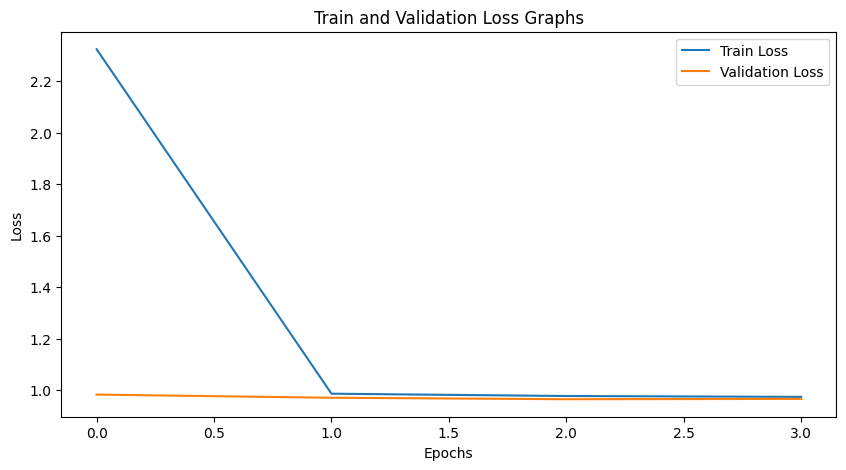

In [342]:
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Train and Validation Loss Graphs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

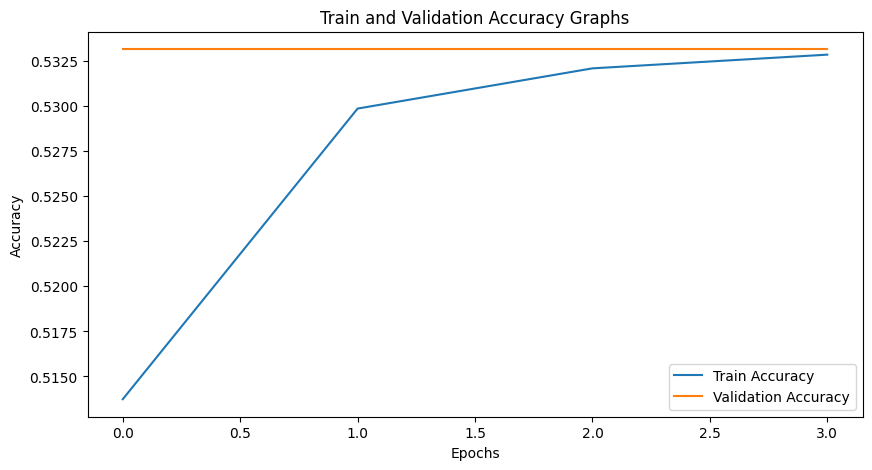

In [343]:
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Train and Validation Accuracy Graphs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Validation sur les données de Test

### Filtrage des tokens
Suppression des mots vides (stopwords) grâce à NLTK, puis filtre des tokens de longueur <= 2 pour éviter le bruit.

In [ ]:
# On part de X_test qui est une liste de chaînes (padding retiré)
# Si ce n’est pas déjà le cas, transformez-le en Series :
X_test = pd.Series(X_test)

# 1. Retirer les URLs
X_test = X_test.apply(remove_url)

# 2. Retirer les nombres
X_test = X_test.apply(remove_number)

# 3. Retirer le HTML et entités
X_test = X_test.apply(remove_html)

# 4. Ne garder que les lettres
X_test = X_test.apply(remove_punctuations)

# 5. Tokenisation  par découpage sur les espaces
X_test = X_test.apply(simple_tokenize)

# 6. Suppression des stopwords
X_test = X_test.apply(stopwords_remove)

# 7. Filtrage sur la longueur des mots
X_test = X_test.apply(word_length_filter)

# 8. On reconstitue des chaînes pour le Tokenizer Keras
X_test = X_test.str.join(' ')

tokenized_test = tokenizer.texts_to_sequences(X_test)
padded_test = pad_sequences(tokenized_test, maxlen=maxlen, padding='pre')

### Accuracy

In [346]:
pred_test_lstm = model.predict(padded_test)
test_evaluate = model.evaluate(padded_test, y_test)

206/206 ━━━━━━━━━━━━━━━━━━━━ 21s 100ms/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 23s 112ms/step - accuracy: 0.5334 - loss: 0.9811


### Precision, Recall, F1-score

In [347]:
from sklearn.metrics import classification_report

y_pred_classes = pred_test_lstm.argmax(axis=1)

report = classification_report(
    y_test,
    y_pred_classes,
    target_names=label_encoder.classes_,  
    digits=4                             
)

print(report)


                  precision    recall  f1-score   support

Credit reporting     0.0000    0.0000    0.0000      2501
 Debt collection     0.5332    1.0000    0.6955      3506
     Payday loan     0.0000    0.0000    0.0000       145
    Student loan     0.0000    0.0000    0.0000       424

        accuracy                         0.5332      6576
       macro avg     0.1333    0.2500    0.1739      6576
    weighted avg     0.2842    0.5332    0.3708      6576



/Users/victorouledi/miniforge3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/victorouledi/miniforge3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/victorouledi/miniforge3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



### On voit que le modèle ne prédit qu'une seule classe à chaque fois qui est celle majoritaire

### ROC Curve

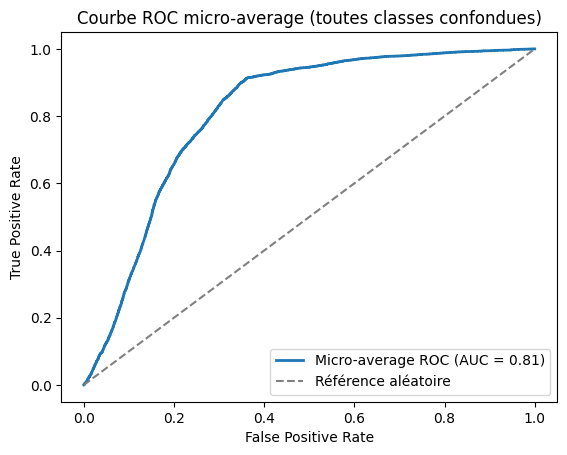

In [348]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# 1) Binarisation des labels (3 classes : 0,1,2)
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# 2) Aplatir les tableaux pour la micro-average
y_true_flat  = y_test_binarized.ravel()         # vecteur de 0/1 pour chaque classe et chaque échantillon
y_score_flat = pred_test_lstm.ravel()           # probas correspondantes

# 3) Calcul de la ROC et de l’AUC micro-average
fpr_micro, tpr_micro, _ = roc_curve(y_true_flat, y_score_flat)
roc_auc_micro = auc(fpr_micro, tpr_micro)

# 4) Tracé de la courbe unique
plt.figure()
plt.plot(fpr_micro, tpr_micro, lw=2, label=f"Micro-average ROC (AUC = {roc_auc_micro:.2f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Référence aléatoire')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Courbe ROC micro-average (toutes classes confondues)')
plt.legend(loc='lower right')
plt.show()


### On retrouve une bonne performance générale du modèle mais du à la sur représentation d'une classe pour laquelle le modèle a appris uniquement à opter pour 

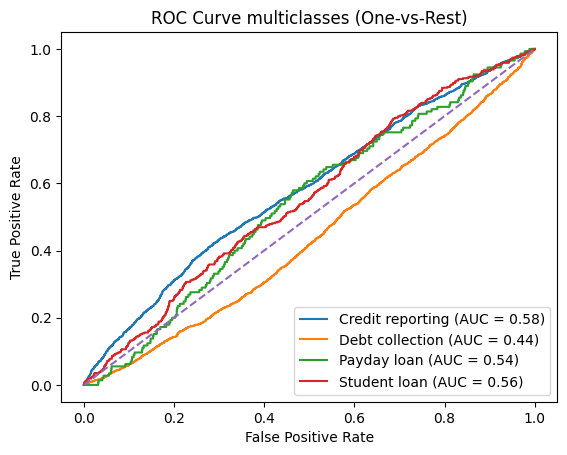

In [349]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# 1) Binariser vos labels de test (3 classes : 0,1,2)
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])
n_classes = y_test_binarized.shape[1]

# 2) Calculer fpr, tpr, AUC pour chaque classe
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(
        y_test_binarized[:, i],
        pred_test_lstm[:, i]   # probabilité prédite pour la classe i
    )
    roc_auc[i] = auc(fpr[i], tpr[i])

# 3) Tracer la courbe
plt.figure()
for i in range(n_classes):
    plt.plot(
        fpr[i],
        tpr[i],
        label=f"{label_encoder.classes_[i]} (AUC = {roc_auc[i]:.2f})"
    )
# Diagonale de référence (classif. aléatoire)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve multiclasses (One-vs-Rest)')
plt.legend(loc='lower right')
plt.show()


### En regardant la ROC One VS Rest on voit bien que les performances du modèle à distinguer les classes sont très mauvaises

### Exemple de prédiction

In [350]:

df_results = pd.DataFrame({
    'text': X_test,                            
    'true_label': y_test,                      
    'pred_proba_0': pred_test_lstm[:, 0],     
    'pred_proba_1': pred_test_lstm[:, 1],      
    'pred_proba_2': pred_test_lstm[:, 2],     
    'pred_proba_3': pred_test_lstm[:, 3],      
 
})

df_results['pred_label'] = np.argmax(pred_test_lstm, axis=1)

df_results['true_label_name'] = label_encoder.inverse_transform(df_results['true_label'])
df_results['pred_label_name'] = label_encoder.inverse_transform(df_results['pred_label'])

df_results['pred_confidence'] = df_results.apply(
    lambda row: row[f'pred_proba_{row.pred_label}'], axis=1
)
df_results.head(10)

,text,true_label,pred_proba_0,pred_proba_1,pred_proba_2,pred_proba_3,pred_label,true_label_name,pred_label_name,pred_confidence
0,xxxx xxxx xxxx received xxxx debt collection letters erc regarding xxxx debts xxxx xxxx xxxx xxxx amount xxxx amount received another collection letter erc xxxx xxxx xxxx another debt amount not owe debts already sent submitted proof xxxx last year regarding another debt,1,0.393808,0.497076,0.030616,0.078499,1,Debt collection,Debt collection,0.497076
1,collection equifax credit report xxxx checking account equifax listed credit card loan checking act secondly paid xxxx told file dispute got paper work bank get hold equifax would prefer phone,0,0.392835,0.494570,0.031946,0.080649,1,Credit reporting,Debt collection,0.494570
2,sent several letters midland credit management validate debt claim owe failed send proper documentation validate debt claim owe last letter sent returned back insufficient address notices address,1,0.392648,0.494133,0.032187,0.081032,1,Debt collection,Debt collection,0.494133
3,debt phone service paid thru xxxx checked credit report says still owe phone bill says diversified agency take xxxx debt diversified,1,0.393358,0.496012,0.031196,0.079435,1,Debt collection,Debt collection,0.496012
4,xxxx xxxx firm contacted estranged spouse never gave contact loan documents told wrote bad check attempting get contact texted contact number called knew not checks written company reason spoke agent placed male coworker line stated attorney xxxx charged fraudulent check fraudulent use closed bank account processing papers arrested within week,1,0.392860,0.494647,0.031907,0.080586,1,Debt collection,Debt collection,0.494647
5,fco fair collections outsourcing calling threatening phone collection xxxx apartments xxxxcalifornia evicted xxxx daughters apartment xxxx injured xxxx xxxx xxxxcalifornia xxxx paid properly xxxx employer xxxx home xxxx xxxx respectfully permanent xxxx retired xxxx send evidence collections medical evidence consumers financial protection bureau emails xxxx stress xxxx military veteran xxxx xxxx xxxx citizen xxxxcalifornia fair collections outsourcing ruined credit xxxx not obtain consumer loan xxxx daughters college education xxxx daughters wants continue education xxxx careers credit ruined fco even sent document reduction pay xxxxi always paid rent time daughters xxxx discriminated retaliated xxxx fco collections outsourcing since xxxx till present fco collections outsourcing xxxx xxxxcalifornia xxxx staff discriminated managers xxxx longer xxxx apartments even hired attorneys collect debts evictions file complaints fco collections outsourcing xxxx apartments federal trade commission xxxx nothing done send notifications president obama congress issues xxxx xxxx,1,0.393991,0.497685,0.030319,0.078005,1,Debt collection,Debt collection,0.497685
6,xxxx contacted capital collection services verify account unfamiliar receiving information unsure requested letter physical account refused send letter said sent letters back not send another today think horrible expect documentation anything could happening time,1,0.392474,0.493667,0.032434,0.081426,1,Debt collection,Debt collection,0.493667
7,xxxx reporting xxxx xxxx xxxxpursuant fdcpa reporting agency required provide reporting information contact information may validate absence information must removed reporting,0,0.393007,0.494976,0.031725,0.080293,1,Credit reporting,Debt collection,0.494976
8,credit bureau would not properly investigate public records not mine according state xxxx department treasury xxxx county court clerk recorder not verify information fcra deem public records valid without contacting source court stated not verify information credit bureaus sent investigation accordance fair credit reporting act section refused respond broken law letters sent certified documentation,0,0.392434,0.493564,0.032488,0.081515,1,Credit reporting,Debt collection,0.493564
9,putting complaint diversified consultants reporting collec

### Les performances relatées par la ROC cruve One VS Rest sont en effet très mauvaises, cela était dû au mauvaise équilibraque des classes cibles dans le jeu d'entrainement en effet une classe était bien sur représentée, le modèle n'à qu'à apprendre à prédire la classe majoritaire à chaque fois mais ne les distingue pas bien. On le voit bien dans les exemples de prédicitons

Rappel : 


Nombre d'exemples par classe :
- Classe 0 (Credit reporting): 7504 exemples
- Classe 1 (Debt collection): 10516 exemples
- Classe 2 (Payday loan): 434 exemples
- Classe 3 (Student loan): 1272 exemples

### Notre enjeux est donc de gérer ce désiquilibre de classe 

# 3. Gestion de la classe Inbalance

#### **1. Utilisation du sur et sous echantillonnage**

Nous utilisons à la fois du sur et du sous-échantillonnage. En effet utiliser uniquement du sur échantillonnage dans un contexte où il y a un gros déséquilibre de classe reviendrait à dupliquer beaucoup de fois les valeurs des classes minoritaires ce qui engendre un risque de sur apprentissage sur les mêmes données. Utiliser uniquement du sous échantillonnage reviendrait à perdre trop d'information pour une meilleure généralisation, ainsi on utilise les 2 méthodes. 

In [370]:
import numpy as np
import pandas as pd

# --- a) Regrouper X_train et y_train dans un DataFrame pour rééchantillonnage
df = pd.DataFrame({
    'text': X_train,     # vos textes nettoyés sous forme de chaînes
    'label': y_train     # vos labels entiers 0,1,2
})

# 1. Définir la taille cible après sous-/sur-échantillonnage
#   On définit 200 exemples par classe
target_size = 2000

# 2. Sous-échantillonner la classe majoritaire (0)
df_maj = df[df.label == 0].sample(n=target_size, random_state=42, replace=False)
df_maj2 = df[df.label == 1].sample(n=target_size, random_state=42, replace=False)

# 3. Sur-échantillonner les classes minoritaires (1 et 2)
df_min1 = df[df.label == 2].sample(n=target_size, random_state=42, replace=True)
df_min2 = df[df.label == 3].sample(n=target_size, random_state=42, replace=True)

# 4. Concaténer pour obtenir un DataFrame équilibré
df_balanced = pd.concat([df_maj, df_min1, df_min2, df_maj2]).sample(frac=1, random_state=42)

# 5. Reconstruire X_train et y_train
X_train_bal = df_balanced['text'].tolist()
y_train_bal = df_balanced['label'].values

# --- b) Vectorisation + padding sur le jeu ré-équilibré
seq_train_bal   = tokenizer.texts_to_sequences(X_train_bal)
padded_train_bal = pad_sequences(seq_train_bal, maxlen=maxlen, padding='pre')

# padded_val et y_test restent inchangés pour la validation

# --- c) Entraînement du modèle avec both sur-/sous-échantillonnage 
history_balanced = model.fit(
    padded_train_bal, y_train_bal,
    validation_data=(padded_val, y_val), 
    epochs=10,
    batch_size=32,
    callbacks=[early_stopping]
)




Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 122s 481ms/step - accuracy: 0.2773 - loss: 7.0321 - val_accuracy: 0.3803 - val_loss: 1.3762
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 129s 517ms/step - accuracy: 0.5157 - loss: 1.1242 - val_accuracy: 0.3803 - val_loss: 1.2250
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 143s 571ms/step - accuracy: 0.6975 - loss: 0.7615 - val_accuracy: 0.5312 - val_loss: 1.2214
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 144s 577ms/step - accuracy: 0.8081 - loss: 0.5773 - val_accuracy: 0.3812 - val_loss: 1.4204
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 129s 518ms/step - accuracy: 0.8408 - loss: 0.5111 - val_accuracy: 0.3805 - val_loss: 3.2189
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 126s 502ms/step - accuracy: 0.8737 - loss: 0.4521 - val_accuracy: 0.3805 - val_loss: 3.2451


206/206 ━━━━━━━━━━━━━━━━━━━━ 22s 107ms/step


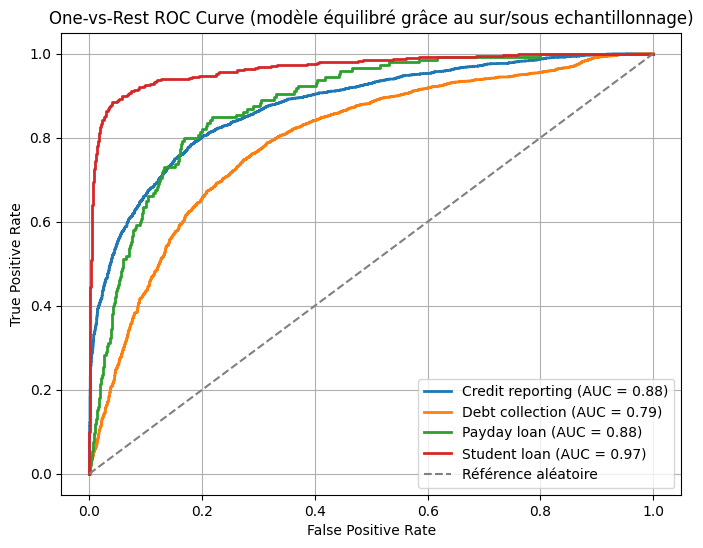

In [371]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# 1. Prédictions probabilistes du modèle équilibré
pred_test_bal = model.predict(padded_test)

# 2. Binarisation des labels de test
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])
n_classes = y_test_binarized.shape[1]

# 3. Calcul des courbes ROC et AUC pour chaque classe
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], pred_test_bal[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 4. Affichage
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(
        fpr[i], tpr[i], lw=2,
        label=f"{label_encoder.classes_[i]} (AUC = {roc_auc[i]:.2f})"
    )
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Référence aléatoire')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('One-vs-Rest ROC Curve (modèle équilibré grâce au sur/sous echantillonnage)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


#### **2. Utilisation de la pondération**

La pondération des classes consiste à ajuster la contribution de chaque exemple à la fonction de perte en fonction de la fréquence de sa classe, de façon à compenser les déséquilibres de distribution.

Sans pondération, le modèle peut « oublier » les classes rares en se focalisant sur la classe majoritaire (qui minimise plus facilement la perte globale).Avec class_weight, on rééquilibre virtuellement le signal de la perte pour que chaque classe, qu’elle soit fréquente ou non, influence équitablement l’optimisation.

In [353]:
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.sequence import pad_sequences



# --- c) Calcul des class weights sur le jeu ré-équilibré
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(class_weights))
print("Class weights :", class_weight_dict)


history_weighted = model.fit(
    padded_train, y_train,
    validation_data=(padded_val, y_val),  
    epochs=10,
    batch_size=32,
    class_weight=class_weight_dict,
    callbacks=[early_stopping]
)

Class weights : {0: 0.6571828358208955, 1: 0.46895207303157094, 2: 11.362903225806452, 3: 3.8769654088050314}
Epoch 1/10
617/617 ━━━━━━━━━━━━━━━━━━━━ 4143s 7s/step - accuracy: 0.3597 - loss: 1.4579 - val_accuracy: 0.5332 - val_loss: 1.3839
Epoch 2/10
617/617 ━━━━━━━━━━━━━━━━━━━━ 313s 508ms/step - accuracy: 0.2271 - loss: 1.4347 - val_accuracy: 0.5330 - val_loss: 1.3571
Epoch 3/10
617/617 ━━━━━━━━━━━━━━━━━━━━ 643s 1s/step - accuracy: 0.4286 - loss: 1.3951 - val_accuracy: 0.3803 - val_loss: 1.3736
Epoch 4/10
617/617 ━━━━━━━━━━━━━━━━━━━━ 315s 510ms/step - accuracy: 0.2982 - loss: 1.4025 - val_accuracy: 0.5332 - val_loss: 1.3799


206/206 ━━━━━━━━━━━━━━━━━━━━ 21s 104ms/step


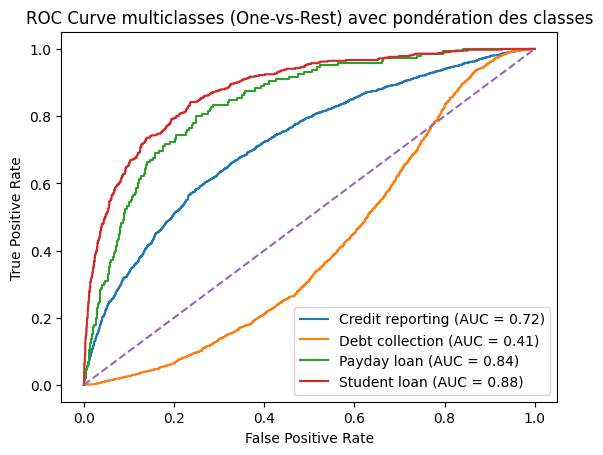

In [365]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# 1. Prédictions probabilistes du modèle équilibré
pred_test_lstm = model.predict(padded_test)

y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])
n_classes = y_test_binarized.shape[1]

# 2) Calculer fpr, tpr, AUC pour chaque classe
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(
        y_test_binarized[:, i],
        pred_test_lstm[:, i]   # probabilité prédite pour la classe i
    )
    roc_auc[i] = auc(fpr[i], tpr[i])

# 3) Tracer la courbe
plt.figure()
for i in range(n_classes):
    plt.plot(
        fpr[i],
        tpr[i],
        label=f"{label_encoder.classes_[i]} (AUC = {roc_auc[i]:.2f})"
    )
# Diagonale de référence (classif. aléatoire)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve multiclasses (One-vs-Rest) avec pondération des classes')
plt.legend(loc='lower right')
plt.show()

#### **On conclut que le sur et sous échantillonnage est meilleur que la pondération des classes**

# 4. Amélioration des performances grâce à la Cross validation



Pour optimiser les performances de notre LSTM bidirectionnel, nous avons utilisé **Keras Tuner** afin de tester plusieurs configurations d’hyper-paramètres clés :

- **Dimension de l’Embedding (`embed_dim`)**  
  Valeurs testées : `100`, `200`, `300`  
  > Plus la dimension est grande, plus les vecteurs de mots peuvent capturer de nuances sémantiques, mais cela augmente aussi le nombre de paramètres.

- **Taille des couches LSTM (`lstm_units`)**  
  Valeurs testées : `32`, `64`, `128`  
  > Nombre de cellules cachées dans chaque direction du LSTM bidirectionnel. Un nombre supérieur permet de modéliser des dépendances plus longues, au prix d’un surcoût computationnel.

- **Taux de Dropout après l’Embedding (`dropout_emb`)**  
  Valeurs testées : de `0.2` à `0.5` (pas `0.1`)  
  > Sert à régulariser la couche d’Embedding en forçant le modèle à ne pas trop dépendre de quelques dimensions.

- **Taux de Dropout après chaque LSTM (`dropout_lstm`)**  
  Valeurs testées : de `0.2` à `0.5` (pas `0.1`)  
  > Permet de réduire le sur-apprentissage dans la partie récurrente du réseau.

- **Taux de Dropout avant et après la couche Dense (`dropout_dense`)**  
  Valeurs testées : de `0.2` à `0.5` (pas `0.1`)  
  > Aide à généraliser les représentations extraites par les LSTM avant la classification finale.

- **Learning Rate de l’optimiseur Adam (`learning_rate`)**  
  Valeurs testées : `1e-3`, `5e-4`, `1e-4`  
  > Le pas d’apprentissage influe sur la vitesse et la stabilité de la convergence.


### Cross validation

In [355]:
import keras_tuner as kt
import tensorflow as tf

def build_model(hp):
    embed_dim = hp.Choice('embed_dim', [100, 200, 300])
    lstm_out  = hp.Choice('lstm_out',  [32, 64, 128])
    dropout_e = hp.Float('dropout_emb', min_value=0.2, max_value=0.5, step=0.1)
    dropout_l = hp.Float('dropout_lstm', min_value=0.2, max_value=0.5, step=0.1)
    dropout_d = hp.Float('dropout_dense', min_value=0.2, max_value=0.5, step=0.1)
    lr        = hp.Choice('learning_rate', [1e-3, 5e-4, 1e-4])

    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(num_words, embed_dim, input_length=maxlen),
        tf.keras.layers.Dropout(dropout_e),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_out, return_sequences=True,
            kernel_regularizer=tf.keras.regularizers.l2(0.01),
            recurrent_regularizer=tf.keras.regularizers.l2(0.01))),
        tf.keras.layers.Dropout(dropout_l),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_out,
            kernel_regularizer=tf.keras.regularizers.l2(0.01),
            recurrent_regularizer=tf.keras.regularizers.l2(0.01))),
        tf.keras.layers.Dropout(dropout_d),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(dropout_d),
        tf.keras.layers.Dense(n_classes, activation='softmax'),
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='kt_dir',
    project_name='lstm_tuning'
)


# Lancement de la recherche
tuner.search(
    padded_train_bal, y_train_bal,
    validation_data=(padded_val, y_val),  # <-- idem ici
    epochs=10,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=0
)

# Meilleurs hyperparamètres
best_hp = tuner.get_best_hyperparameters()[0]
print(best_hp.values)


Reloading Tuner from kt_dir/lstm_tuning/tuner0.json
{'embed_dim': 300, 'lstm_out': 32, 'dropout_emb': 0.2, 'dropout_lstm': 0.2, 'dropout_dense': 0.30000000000000004, 'learning_rate': 0.001}


### Re spécification du modèle

In [357]:
# Hyper‐paramètres optimisés
embed_dim     = 300
lstm_units    = 32
dropout_emb   = 0.2
dropout_lstm  = 0.2
dropout_dense = 0.3
learning_rate = 1e-3
n_classes     = len(label_encoder.classes_)
maxlen        = max_sequence_length
num_words     = len(tokenizer.word_index) + 1  

# Création du modèle “upgradé”
model_upgrade = Sequential(name='model_upgrade')
model_upgrade.add(Embedding(
    input_dim=num_words,
    output_dim=embed_dim,
    input_length=maxlen,
    name='embedding_layer'
))
model_upgrade.add(Dropout(dropout_emb, name='dropout_embedding'))

model_upgrade.add(Bidirectional(LSTM(
    lstm_units,
    return_sequences=True,
    kernel_regularizer=tf.keras.regularizers.l2(0.01),
    recurrent_regularizer=tf.keras.regularizers.l2(0.01),
    name='bidir_lstm_1'
)))
model_upgrade.add(Dropout(dropout_lstm, name='dropout_lstm_1'))

model_upgrade.add(Bidirectional(LSTM(
    lstm_units,
    kernel_regularizer=tf.keras.regularizers.l2(0.01),
    recurrent_regularizer=tf.keras.regularizers.l2(0.01),
    name='bidir_lstm_2'
)))
model_upgrade.add(Dropout(dropout_dense, name='dropout_lstm_2'))

model_upgrade.add(Dense(64, activation='relu', name='dense_relu'))
model_upgrade.add(Dropout(dropout_dense, name='dropout_dense'))

model_upgrade.add(Dense(n_classes, activation='softmax', name='output_layer'))

# Compile with upgraded learning rate
optimizer = Adam(learning_rate=learning_rate)
model_upgrade.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

# Build et résumé
model_upgrade.build(input_shape=(None, maxlen))
model_upgrade.summary()

history_upgrade = model_upgrade.fit(
    padded_train_bal, y_train_bal,
    validation_data=(padded_val, y_val),  
    epochs=10,
    batch_size=32,
    callbacks=[early_stopping]
)

Model: "model_upgrade"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_layer (Embedding)     │ (None, 544, 300)       │     6,462,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_embedding (Dropout)     │ (None, 544, 300)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_20                │ (None, 544, 64)        │        85,248 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm_1 (Dropout)        │ (None, 544, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_21                │ (None, 64)             │        24,832 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm_2 (Dropout)        │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_relu (Dense)              │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_dense (Dropout)         │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,577,100 (25.09 MB)

 Trainable params: 6,577,100 (25.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 95s 371ms/step - accuracy: 0.3865 - loss: 3.9355 - val_accuracy: 0.3803 - val_loss: 1.2009
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 105s 421ms/step - accuracy: 0.6955 - loss: 0.8081 - val_accuracy: 0.3805 - val_loss: 1.7374
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 102s 407ms/step - accuracy: 0.8330 - loss: 0.5332 - val_accuracy: 0.5330 - val_loss: 1.2922
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 102s 407ms/step - accuracy: 0.8943 - loss: 0.4067 - val_accuracy: 0.3805 - val_loss: 1.7311
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 112s 450ms/step - accuracy: 0.9382 - loss: 0.2946 - val_accuracy: 0.3803 - val_loss: 2.9612
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 111s 444ms/step - accuracy: 0.9563 - loss: 0.2205 - val_accuracy: 0.3805 - val_loss: 3.3378


206/206 ━━━━━━━━━━━━━━━━━━━━ 14s 66ms/step


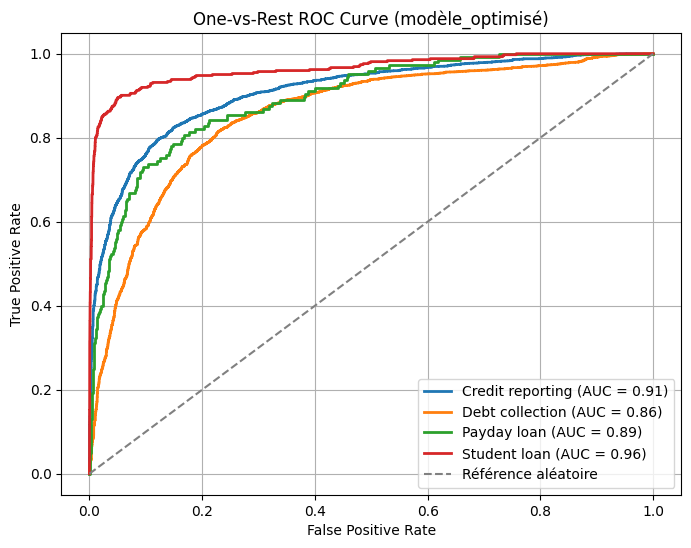

In [363]:


# 1. Prédictions probabilistes du modèle “upgradé”
pred_test_upgrade = model_upgrade.predict(padded_test)

# 2. Binarisation des labels de test
y_test_binarized = label_binarize(y_test, classes=list(range(n_classes)))
n_classes = y_test_binarized.shape[1]

# 3. Calcul des courbes ROC et AUC One-vs-Rest pour chaque classe
fpr = {}
tpr = {}
roc_auc = {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], pred_test_upgrade[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 4. Affichage
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(
        fpr[i], tpr[i], lw=2,
        label=f"{label_encoder.classes_[i]} (AUC = {roc_auc[i]:.2f})"
    )
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Référence aléatoire')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('One-vs-Rest ROC Curve (modèle_optimisé)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [360]:
from sklearn.metrics import classification_report

y_pred_classes = pred_test_upgrade.argmax(axis=1)

report = classification_report(
    y_test,
    y_pred_classes,
    target_names=label_encoder.classes_,  
    digits=4                             
)

print(report)

                  precision    recall  f1-score   support

Credit reporting     0.7321    0.8513    0.7872      2501
 Debt collection     0.8534    0.6640    0.7469      3506
     Payday loan     0.1772    0.6552    0.2790       145
    Student loan     0.8391    0.7995    0.8188       424

        accuracy                         0.7438      6576
       macro avg     0.6505    0.7425    0.6580      6576
    weighted avg     0.7914    0.7438    0.7565      6576



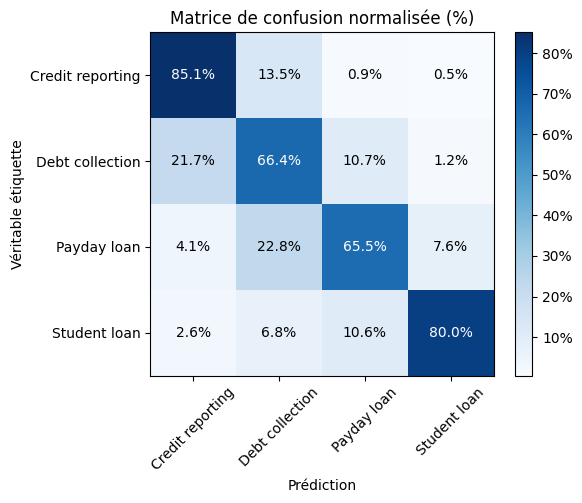

In [362]:
from sklearn.metrics import confusion_matrix
cm_norm = confusion_matrix(y_test, y_pred_classes, normalize='true')

cm_norm_df = pd.DataFrame(
    cm_norm * 100,                          
    index=label_encoder.classes_,
    columns=label_encoder.classes_
)

plt.figure(figsize=(6, 5))
plt.imshow(cm_norm_df, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Matrice de confusion normalisée (%)")
plt.colorbar(format='%0.0f%%')
plt.xticks(range(len(cm_norm_df)), cm_norm_df.columns, rotation=45)
plt.yticks(range(len(cm_norm_df)), cm_norm_df.index)
plt.xlabel("Prédiction")
plt.ylabel("Véritable étiquette")

thresh = cm_norm.max() / 2
for i in range(cm_norm_df.shape[0]):
    for j in range(cm_norm_df.shape[1]):
        plt.text(
            j, i,
            f"{cm_norm_df.iat[i, j]:.1f}%",
            ha="center",
            va="center",
            color="white" if cm_norm_df.iat[i, j]/100 > thresh else "black"
        )

plt.tight_layout()
plt.show()

### On a a de bien meilleures meilleures performances. Les performances de classificaitions relatives à la classe Payday Loan reste moindre car la catégorie aura été beaucoup sur échantillonné ce qui créer du sur apprentissage et empêche forcément une meilleure généralisation possible sur le jeu de test

# Amélioration de la méthode et perspective

Les performances initiales du modèle étant mauvaises nous avons réussi à trouver des technniques pour les améliorer. Nous aurions pu aller cependant plus loins en  afinnant les techniques de rééquilibrage des données en faisant varier le nombre de données voulant être atteint pour le sur et sous échantillonnage.


De même nous aurions pu tester plus de valeurs pour notre analyse de sensibilités des performances par cross validation. 

Il aurait également été possible de faire une analyse de sensibilité en fonction de la taille des commentaires considérés (en nombre de mots) ainsi qu'en fonction de la taille des mots sélectionnés pour le travail (rappel : nous avons sélectionné uniquement les mots supérieurs 2 caractères) 